# **Ambiente**

## Libraries and functions

### Installing libraries

In [2]:
%pip install geopandas shapely matplotlib zipfile36 verde -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pystac-client pyproj rasterio -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Para Colab:
#!apt-get install -y gdal-bin python3-gdal
#!gdalinfo --version
#!pip install planetary_computer -q

#Local
%pip install gdal

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install planetary_computer -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
#!pip install cmocean -q
%pip install cmocean -q

Note: you may need to restart the kernel to use updated packages.


### Imports

In [7]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
#import verde as vd
import requests

from shapely.geometry import Polygon

c:\Users\Luizemara\.conda\envs\mapas\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [8]:
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [9]:
import cmocean

### Local functions

###### Função para plotar 2 mapas do Brasil

In [10]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Função para dados espúrios. Correção de caracteres fora do esperado (pontuação de milhar, vírgula, etc).

In [11]:
def correct_grav_obs_value(value):
    """
    Função para corrigir valores da coluna GRAV_OBS:
    - Remove múltiplos pontos, mantendo apenas o último
    - Substitui vírgulas por pontos
    - Remove caracteres não numéricos
    """
    if pd.isnull(value):
        return value  # Retorna o valor original se for NaN

    # Garantir que o valor é uma string e remover espaços extras
    value = str(value).strip()

    # Substituir vírgulas por pontos
    value = value.replace(',', '.')

    # Se o valor não for uma string válida, retornar None
    if not isinstance(value, str) or value == '':
        return None

    # Corrigir múltiplos pontos, mantendo apenas o último
    if value.count('.') > 1:
        parts = value.split('.')
        value = ''.join(parts[:-1]) + '.' + parts[-1]

    # Converter para float, se possível
    try:
        return float(value)
    except ValueError:
        print ('Erro ao corrigir:', value)
        return None

###### Haversine - distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [12]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [13]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

In [14]:
# Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE

'''file_path = '/content/brasil_shapefile/BR_UF_2021.shp'
if os.path.exists(file_path):
  print(f"The file {file_path} already exists.")
else:
  # Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
  !wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
  !unzip brasil.zip -d /content/brasil_shapefile
  brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')
  print(f"The file {file_path} was downloaded succesifully.")

brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')'''

# Local
url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip"
zip_path = "brasil.zip"

response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)
print("Download concluído.")

extract_dir = "brasil_shapefile"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extração concluída em: {extract_dir}")

brasil = gpd.read_file('./brasil_shapefile/BR_UF_2021.shp')


Download concluído.
Extração concluída em: brasil_shapefile


In [15]:
def plot_gdf_scatter(x, y, c, cmap, title, centered_to_zero = 'no'):
    try:
      import cmocean
    except:
      %pip install cmocean -q
      import cmocean
    import numpy as np
    import matplotlib.pyplot as plt

    if centered_to_zero == 'no':
      vmin = np.min(c)
      vmax = np.max(c)
    elif centered_to_zero == 'yes':
      vmin = -np.max(c)
      vmax = np.max(c)
    else:
      print('centered_to_zero must be yes or no')
      return

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap,
        s=2,
        alpha=0.8,
        linewidth=0,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label(title)
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

## Study Area

Coordinate system

In [16]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


Area of interest

In [17]:
shapefile_path = "janela-ptrII_pg.shp"

#Criar polígono do entorno
aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0) # corrige geometrias inválidas com buffer(0)
aoi_gdf = aoi_gdf[aoi_gdf.is_valid & (~aoi_gdf.is_empty)] # apagar feições que ainda estão inválidas

# Verificar CRS
if aoi_gdf.crs is None:
    aoi_gdf = aoi_gdf.set_crs(epsg=crs_projeto)
    print(f"CRS vazio. Definido {crs_projeto}.")
else:
    print(f"CRS original: {aoi_gdf.crs}")
    if aoi_gdf.crs.to_epsg() != crs_projeto:
        aoi_gdf = aoi_gdf.to_crs(epsg=crs_projeto)
        print("Reprojetado.")

CRS original: PROJCS["Polyconic_Brasil",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


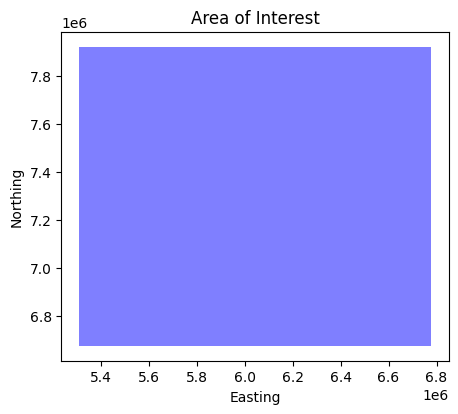

In [18]:
# Obter limites e montar objeto geoJSON
minx, miny, maxx, maxy = aoi_gdf.total_bounds
coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny]   # fecha o poligono
]

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

# Criar um polígono do entorno e exibir
aoi_polygon = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[aoi_polygon])
aoi_gdf = aoi_gdf.set_crs(crs_projeto, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

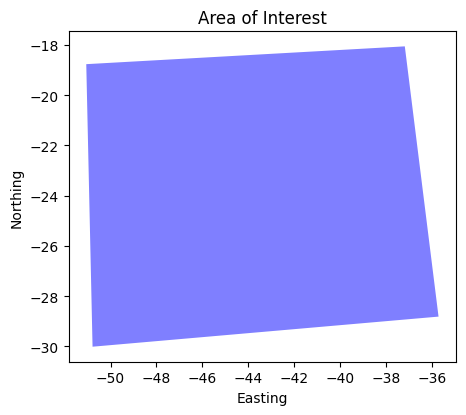

In [19]:
#Versão em geográfica para pesquisa em catálogos STAC

aoi_gdf_wgs84 = aoi_gdf.to_crs("EPSG:4326")
aoi_gdf_wgs84_geom = aoi_gdf_wgs84.geometry.iloc[0]

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf_wgs84.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

# **1. Gravity and topographic data**


## **1.1 Upload and join datasets**

##### **Download de SHPs compactados ([Repositório no Github](https://https://github.com/lszam/gds-ssebrazil/tree/main))**

In [20]:
# Public data zips
sources = ['https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/bgi_20250221.zip', #BGI L. Szameitat (Use upon authorization and DOI)
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/ibge.zip', # last download: July 2025
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/sgb_20250221.zip', # last download: Feb 2025
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/castro2007.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/castro2014.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/barbara-dressel_dgeol-ufpr.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/br_sources/renata-zanella_dgeol-ufpr.zip']


# Local data - Non-public ON data compilation

# Donwload dos dados zip
for url in sources:
    #filename = os.path.join('/content/', url.split('/')[-1]) # colab
    filename = url.split('/')[-1]
    
    try:
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as file:
          for chunk in response.iter_content(chunk_size=8192):
              file.write(chunk)
        print(f"Downloaded {filename} successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")

Downloaded bgi_20250221.zip successfully.
Downloaded ibge.zip successfully.
Downloaded sgb_20250221.zip successfully.
Downloaded castro2007.zip successfully.
Downloaded castro2014.zip successfully.
Downloaded barbara-dressel_dgeol-ufpr.zip successfully.
Downloaded renata-zanella_dgeol-ufpr.zip successfully.


In [21]:
''' # Colab
zip_filenames = []
for url in sources:
  zip_filenames.append(url.split('/')[-1])
file_paths = [os.path.join('/content', url.split('/')[-1]) for url in sources]  # add '/content'
'''
#Local
file_paths = []
for url in sources:
  file_paths.append(url.split('/')[-1])

print(f"Caminhos: {file_paths}")

Caminhos: ['bgi_20250221.zip', 'ibge.zip', 'sgb_20250221.zip', 'castro2007.zip', 'castro2014.zip', 'barbara-dressel_dgeol-ufpr.zip', 'renata-zanella_dgeol-ufpr.zip']


##### **Concatenar SHPs**

Descompactar os arquivos

In [22]:
#extract_dir = '/content/SHP/' # colab
extract_dir = './SHP/' # local

os.makedirs(extract_dir, exist_ok=True)

shapefiles = []
for shapefile in file_paths:
    try:
      with zipfile.ZipFile(shapefile, 'r') as zip:
        print(zip)
        zip.extractall(extract_dir)
        # Salvar shapefiles e o nome do arquivo zip como origem
        shapefiles.extend([(os.path.join(extract_dir, name), shapefile)
                              for name in zip.namelist() if name.endswith('.shp')])
    except Exception as e:
      print(f"Erro ao descompactar {shapefile}:{e}")

print(f"Shapefiles resultantes: {shapefiles}")

<zipfile.ZipFile filename='bgi_20250221.zip' mode='r'>
<zipfile.ZipFile filename='ibge.zip' mode='r'>
<zipfile.ZipFile filename='sgb_20250221.zip' mode='r'>
Erro ao descompactar castro2007.zip:File is not a zip file
<zipfile.ZipFile filename='castro2014.zip' mode='r'>
Erro ao descompactar barbara-dressel_dgeol-ufpr.zip:File is not a zip file
<zipfile.ZipFile filename='renata-zanella_dgeol-ufpr.zip' mode='r'>
Shapefiles resultantes: [('./SHP/sgb_20250221.shp', 'bgi_20250221.zip'), ('./SHP/bgi_20250221.shp', 'bgi_20250221.zip'), ('./SHP/ibge_fev2025.shp', 'ibge.zip'), ('./SHP/sgb_20250221.shp', 'sgb_20250221.zip'), ('./SHP/castro2014.shp', 'castro2014.zip'), ('./SHP/zanella.shp', 'renata-zanella_dgeol-ufpr.zip')]


In [23]:
'''zip_files = [ # Colab
    '/content/anp_lpga.zip',
    '/content/on_bndg.zip',
    '/content/on_iag.zip'
]'''
zip_files = [ # Local
    'anp_lpga.zip',
    'on_bndg.zip',
    'on_iag.zip'
]

for zip_file in zip_files:
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")
    else:
        print(f"Error: {zip_file} not found.")

print("Extraction complete.")

Extracted anp_lpga.zip to ./SHP/
Extracted on_bndg.zip to ./SHP/
Extracted on_iag.zip to ./SHP/
Extraction complete.


In [24]:
# Add other zip_files to shapefiles list

for zip_file in zip_files:
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            shp_in_zip = [name for name in zip_ref.namelist() if name.endswith('.shp')]
            for shp_name in shp_in_zip:
                shapefiles.append((os.path.join(extract_dir, shp_name), zip_file))
    except:
        print(f"Error processing {zip_file}")

print(f"Shapefiles resultantes após arquivos zip adicionais: {shapefiles}")


Shapefiles resultantes após arquivos zip adicionais: [('./SHP/sgb_20250221.shp', 'bgi_20250221.zip'), ('./SHP/bgi_20250221.shp', 'bgi_20250221.zip'), ('./SHP/ibge_fev2025.shp', 'ibge.zip'), ('./SHP/sgb_20250221.shp', 'sgb_20250221.zip'), ('./SHP/castro2014.shp', 'castro2014.zip'), ('./SHP/zanella.shp', 'renata-zanella_dgeol-ufpr.zip'), ('./SHP/anp_lpga.shp', 'anp_lpga.zip'), ('./SHP/on_bndg.shp', 'on_bndg.zip'), ('./SHP/on_iag.shp', 'on_iag.zip')]


Plotar os dados dos shapefiles

Found 10 shapefiles in ./SHP/
Reprojected anp_lpga.shp to EPSG:4326
Processed anp_lpga.shp
Processed bgi_20250221.shp
Reprojected castro2007.shp to EPSG:4326
Processed castro2007.shp
Reprojected castro2014.shp to EPSG:4326
Processed castro2014.shp
Reprojected dressel.shp to EPSG:4326
Processed dressel.shp
Reprojected ibge_fev2025.shp to EPSG:4326
Processed ibge_fev2025.shp
Reprojected on_bndg.shp to EPSG:4326
Processed on_bndg.shp
Reprojected on_iag.shp to EPSG:4326
Processed on_iag.shp
Reprojected sgb_20250221.shp to EPSG:4326
Processed sgb_20250221.shp
Reprojected zanella.shp to EPSG:4326
Processed zanella.shp


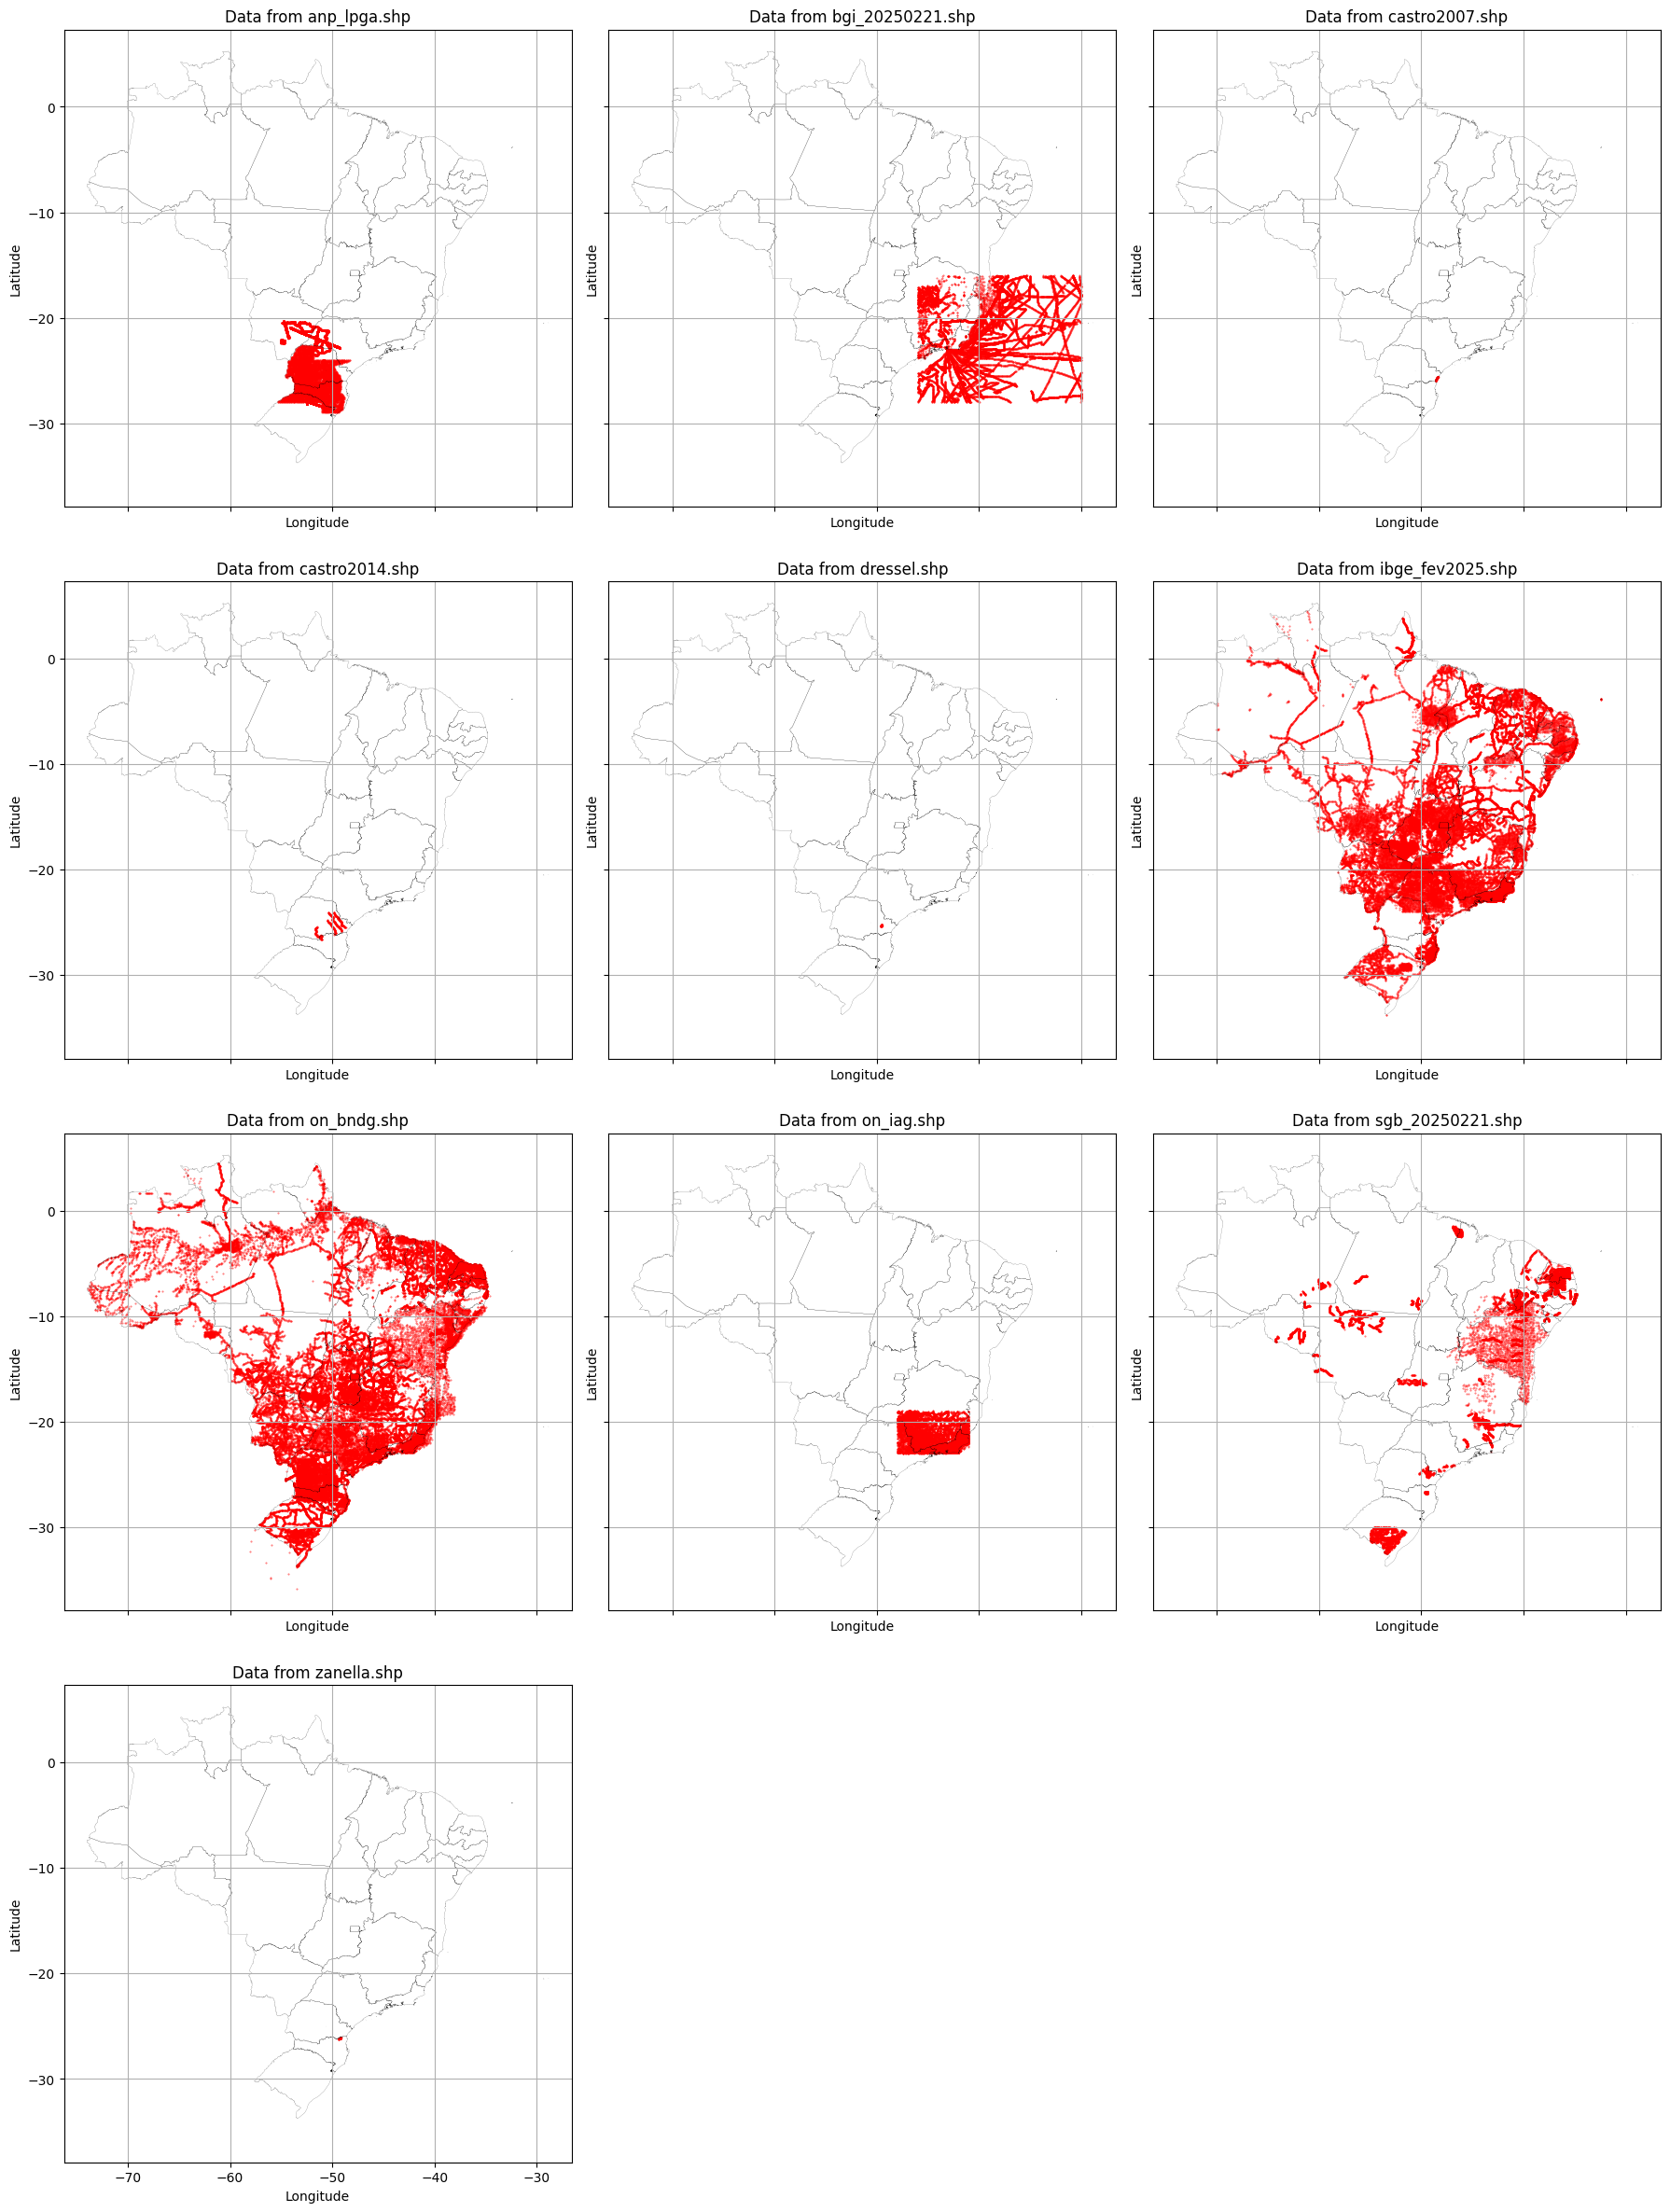

In [25]:
# Plotar os dados dos shapefiles

import pandas as pd
import matplotlib.pyplot as plt
import glob

# Brasil shapefile
# brasil_shp_path = '/content/brasil_shapefile/BR_UF_2021.shp' # Colab
brasil_shp_path = './brasil_shapefile/BR_UF_2022.shp' # Local

if not os.path.exists(brasil_shp_path):
  print(f"Brasil shapefile not found at {brasil_shp_path}. Please upload it or adjust the path.")
else:
  brasil_contour = gpd.read_file(brasil_shp_path)
  brasil_contour = brasil_contour.to_crs("EPSG:4326") # WGS84

  # Ler todos os dados
  all_grav_dfs = []

  shp_files_in_dir = glob.glob(os.path.join(extract_dir, '*.shp'))
  print(f"Found {len(shp_files_in_dir)} shapefiles in {extract_dir}")

  if not shp_files_in_dir:
      print("No shapefiles found in the extraction directory.")
  else:
      for shp_file in shp_files_in_dir:
          try:
              gdf = gpd.read_file(shp_file)
              if 'LATITUDE' in gdf.columns and 'LONGITUDE' in gdf.columns:

                  # Criar a geometria se ela não existir
                  if gdf.geometry.isnull().all():
                      gdf['geometry'] = gpd.points_from_xy(gdf['LONGITUDE'], gdf['LATITUDE'])

                  if gdf.crs is None:
                      gdf = gdf.set_crs("EPSG:4326")
                      print(f"Set CRS to EPSG:4326 for {os.path.basename(shp_file)}")
                  else:
                      if gdf.crs.to_epsg() != 4326:
                           gdf = gdf.to_crs("EPSG:4326")
                           print(f"Reprojected {os.path.basename(shp_file)} to EPSG:4326")

                  # Add source filename for tracking
                  gdf['source_file'] = os.path.basename(shp_file)
                  all_grav_dfs.append(gdf)
                  print(f"Processed {os.path.basename(shp_file)}")
              else:
                  print(f"Skipping {os.path.basename(shp_file)}: Missing LATITUDE or LONGITUDE columns.")
          except Exception as e:
              print(f"Error processing {os.path.basename(shp_file)}: {e}")

      if not all_grav_dfs:
          print("No valid shapefiles with Latitude and Longitude found for plotting.")
      else:
          # Determine the number of subplots
          n_files = len(all_grav_dfs)
          n_cols = 3  # Or adjust based on desired layout
          n_rows = (n_files + n_cols - 1) // n_cols

          fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6), sharex=True, sharey=True)
          # Flatten axes array for easy iteration if it's a 2D array
          if n_rows > 1 or n_cols > 1:
              axes = axes.flatten()
          else:
              axes = [axes] # Ensure axes is iterable even for a single plot

          for i, gdf in enumerate(all_grav_dfs):
              ax = axes[i]
              source_file = gdf['source_file'].iloc[0] if not gdf.empty else "Unknown Source"

              # Plot the gravity points
              if not gdf.empty:
                  # Ensure LATITUDE and LONGITUDE are numeric, convert errors to NaN and drop
                  gdf['LATITUDE'] = pd.to_numeric(gdf['LATITUDE'], errors='coerce')
                  gdf['LONGITUDE'] = pd.to_numeric(gdf['LONGITUDE'], errors='coerce')
                  gdf.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

                  if not gdf.empty:
                      gdf.plot(ax=ax, color='red', markersize=0.2, alpha=0.6)
                  else:
                      print(f"No valid points found after converting to numeric in {source_file}")

              # Plot Brasil contour
              brasil_contour.plot(ax=ax, color='none', edgecolor='black', linewidth=0.1)

              ax.set_title(f'Data from {source_file}')
              ax.set_xlabel('Longitude')
              ax.set_ylabel('Latitude')
              ax.grid(True)

          # Turn off any unused subplots
          for j in range(i + 1, len(axes)):
              fig.delaxes(axes[j])

          plt.tight_layout()
          plt.show()

Combinar em um único objeto tipo gdf

In [26]:
# Ler e concatenar objetos gdf
gdf_list = []
for shp_path, source_name in shapefiles:
    gdf = gpd.read_file(shp_path)

    # Garantir que todos os shapefiles usem o CRS SIRGAS 2000
    if gdf.crs is None:
        gdf.set_crs("EPSG:4674", inplace=True)
    else:
        gdf = gdf.to_crs("EPSG:4674")

    # Salvar o nome do arquivo zip no objeto
    gdf['source_file'] = source_name
    gdf_list.append(gdf)

# Combinar
combined_gdf = pd.concat(gdf_list, ignore_index=True)

# Total de registros em combined_gdf:
print(f"Total de registros combinados: {len(combined_gdf)}")

combined_gdf

Total de registros combinados: 271690


,Line,LONGITUDE,LATITUDE,ALT_ORT,GRAV_OBS,FONTE,geometry,source_file,ALT_GEO,ALT_NOR,ID,GeosoftLin,FA,BOUGUER,LINE,INSTITUICA
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,238.14,978167.79,SGB-CPRM,POINT (-62.15507 -11.18613),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,232.07,978167.09,SGB-CPRM,POINT (-62.15511 -11.19557),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,214.83,978168.31,SGB-CPRM,POINT (-62.15496 -11.20556),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,240.39,978163.82,SGB-CPRM,POINT (-62.15512 -11.21486),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,218.33,978165.31,SGB-CPRM,POINT (-62.1616 -11.22146),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271685,L15102,-45.13,-22.74,530.0,978610.27,NaN,POINT (-45.1337 -22.7446),on_iag.zip,NaN,NaN,NaN,NaN,-30.31,-89.62,NaN,UFO
271686,L15102,-45.15,-22.77,540.0,978612.64,NaN,POINT (-45.1492 -22.7687),on_iag.zip,NaN,NaN,NaN,NaN,-26.41,-86.84,NaN,UFO
271687,L15102,-45.16,-22.78,545.0,978615.91,NaN,POINT (-45.1598 -22.7822),on_iag.zip,NaN,NaN,NaN,NaN,-22.47,-83.45,NaN,UFO
271688,L15102,-45.17,-22.8,545.0,978623.15,NaN,POINT (-45.1732 -22.805),on_iag.zip,NaN,NaN,NaN,NaN,-16.7,-77.68,NaN,UFO


Verificar pontos duplicados, com base nos campos LATITUDE e LONGITUDE. Está sendo considerado que o valor da coordenada arredondado em 8 casas possui precisão suficiente.

In [27]:
combined_gdf['LATITUDE'] = combined_gdf['LATITUDE'].round(8) #precisão da coordenada
combined_gdf['LONGITUDE'] = combined_gdf['LONGITUDE'].round(8)

# Masking duplicates
duplicated_mask = combined_gdf.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep='first')
duplicated_gdf = combined_gdf[duplicated_mask] # True values
unique_gdf = combined_gdf[~duplicated_mask] #False values


# Total de registros em duplicated_gdf:
print("Total de registros duplicados:", len(duplicated_gdf))
# Total de registros em unique_gdf:
print("Total de registros não-duplicados:", len(unique_gdf))

Total de registros duplicados: 34083
Total de registros não-duplicados: 237607


Plot of concatenated data

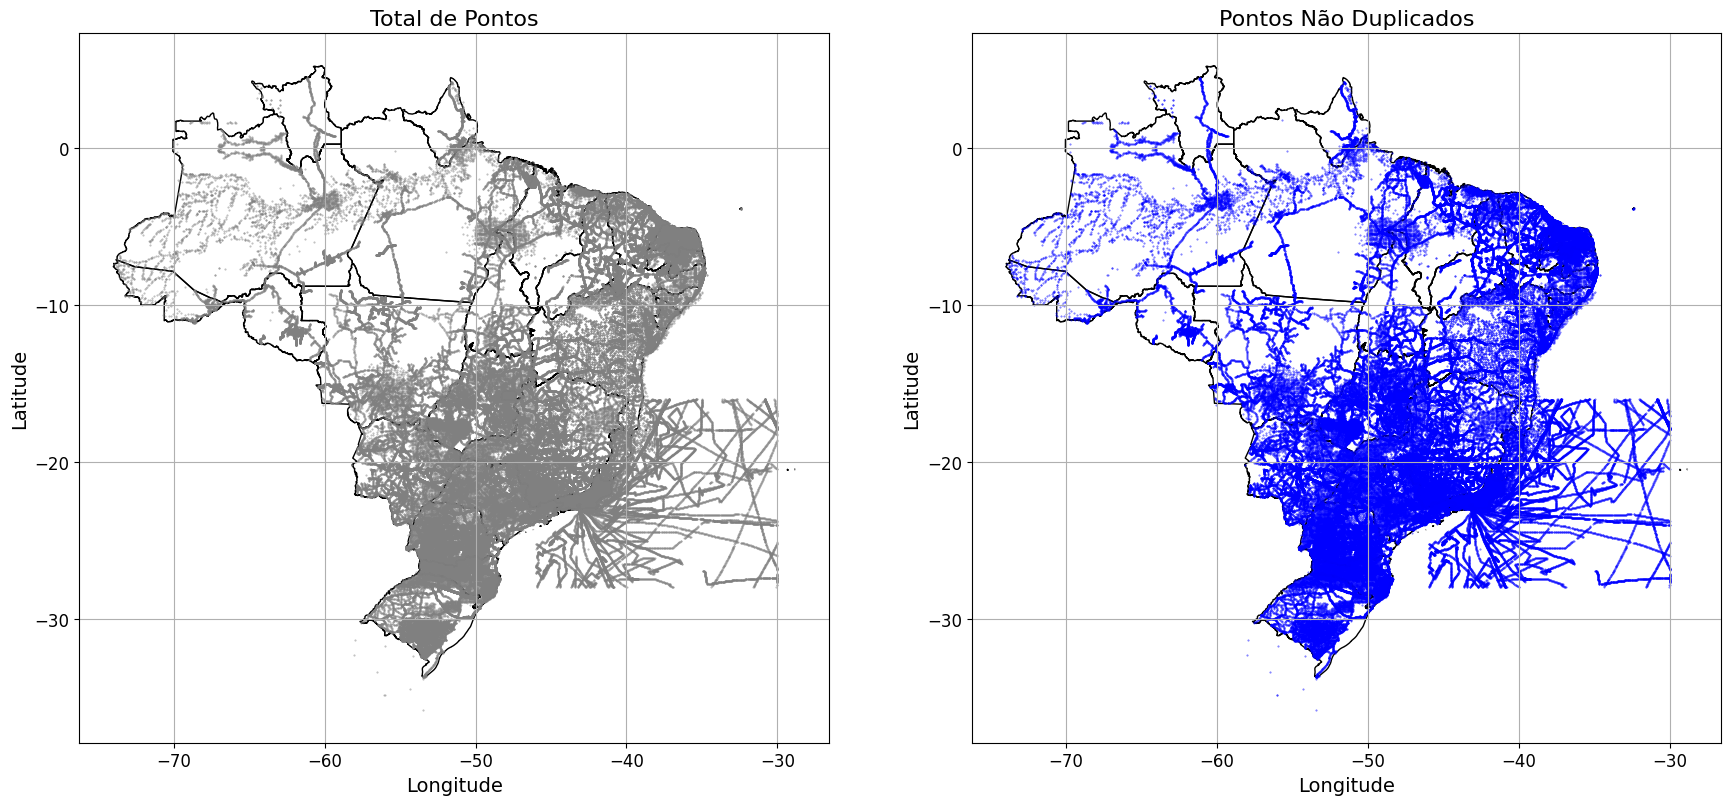

In [28]:
plot_2maps(
    gdf1=combined_gdf, title1='Total de Pontos', color1='grey',
    gdf2=unique_gdf, title2='Pontos Não Duplicados', color2='blue',
    brasil_contour=brasil
)

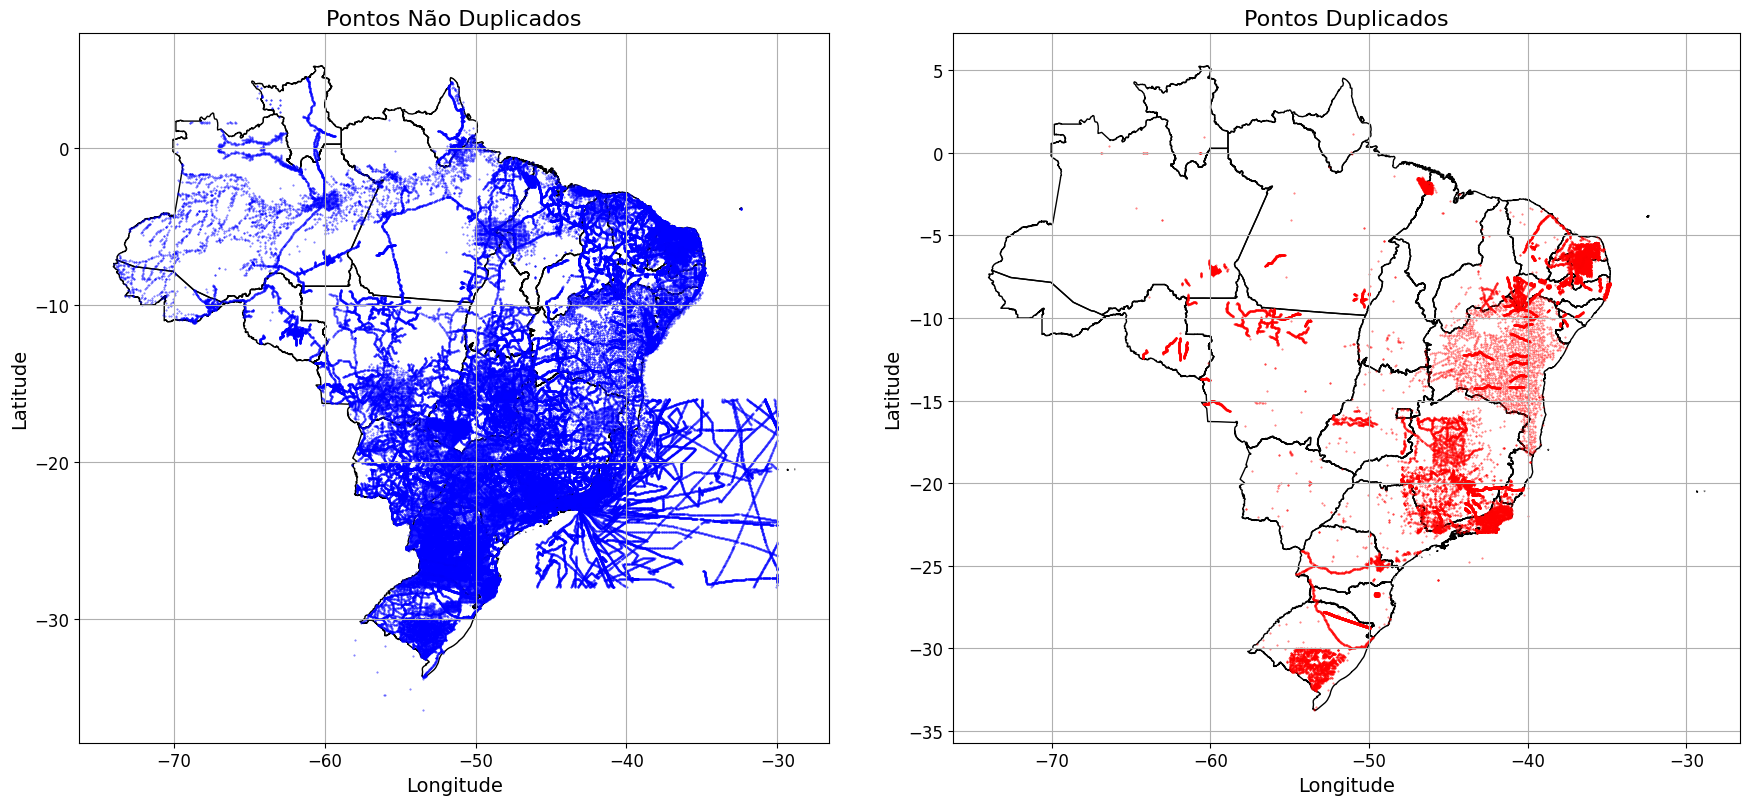

In [29]:
plot_2maps(
    gdf1=unique_gdf, title1='Pontos Não Duplicados', color1='blue',
    gdf2=duplicated_gdf, title2='Pontos Duplicados', color2='red',
    brasil_contour=brasil
)

##### **Correção de caracteres**

In [30]:
# Erros de digitacao ou multiplos pontos, ou virgula para marcar decimal
unique_gdf['GRAV_OBS'] = unique_gdf['GRAV_OBS'].astype(str).apply(correct_grav_obs_value)

print(unique_gdf['GRAV_OBS'].head(10))

# Convertendo a coluna 'GRAV_OBS' para numérico
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'], errors='coerce')

unique_gdf

0    978167.79
1    978167.09
2    978168.31
3    978163.82
4    978165.31
5    978170.00
6    978170.73
7    978171.53
8    978170.48
9    978169.67
Name: GRAV_OBS, dtype: float64


C:\Users\Luizemara\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Line,LONGITUDE,LATITUDE,ALT_ORT,GRAV_OBS,FONTE,geometry,source_file,ALT_GEO,ALT_NOR,ID,GeosoftLin,FA,BOUGUER,LINE,INSTITUICA
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,238.14,978167.79,SGB-CPRM,POINT (-62.15507 -11.18613),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,232.07,978167.09,SGB-CPRM,POINT (-62.15511 -11.19557),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,214.83,978168.31,SGB-CPRM,POINT (-62.15496 -11.20556),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,240.39,978163.82,SGB-CPRM,POINT (-62.15512 -11.21486),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,218.33,978165.31,SGB-CPRM,POINT (-62.1616 -11.22146),bgi_20250221.zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271685,L15102,-45.13,-22.74,530.0,978610.27,NaN,POINT (-45.1337 -22.7446),on_iag.zip,NaN,NaN,NaN,NaN,-30.31,-89.62,NaN,UFO
271686,L15102,-45.15,-22.77,540.0,978612.64,NaN,POINT (-45.1492 -22.7687),on_iag.zip,NaN,NaN,NaN,NaN,-26.41,-86.84,NaN,UFO
271687,L15102,-45.16,-22.78,545.0,978615.91,NaN,POINT (-45.1598 -22.7822),on_iag.zip,NaN,NaN,NaN,NaN,-22.47,-83.45,NaN,UFO
271688,L15102,-45.17,-22.8,545.0,978623.15,NaN,POINT (-45.1732 -22.805),on_iag.zip,NaN,NaN,NaN,NaN,-16.7,-77.68,NaN,UFO


In [31]:
# valores "*" por nan em unique_gdf, e quantos valores foram substituidos

initial_nan_count = unique_gdf.isnull().sum().sum()
unique_gdf.replace('*', np.nan, inplace=True)
final_nan_count = unique_gdf.isnull().sum().sum()

replaced_count = final_nan_count - initial_nan_count

print(f"Number of '*' values replaced with NaN: {replaced_count}")

Number of '*' values replaced with NaN: 315


C:\Users\Luizemara\AppData\Local\Temp\ipykernel_2436\2375093535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_gdf.replace('*', np.nan, inplace=True)


Manter no objeto geopandas apenas as colunas necessárias (coordenadas, gravidade, e altitude ortométrica)

In [32]:
columns_to_keep = ['LATITUDE', 'LONGITUDE', 'GRAV_OBS', 'ALT_ORT', 'source_file', 'geometry']
unique_gdf = unique_gdf[columns_to_keep]
missing_columns = [col for col in columns_to_keep if col not in unique_gdf.columns]

if missing_columns:
    print(f"As seguintes colunas estão faltando: {missing_columns}")
else:
    print("\nDados filtrados com as colunas desejadas:")
    print(unique_gdf.head(10))

# Assegurar que as colunas de números estão como tipo número
unique_gdf['LONGITUDE'] = pd.to_numeric(unique_gdf['LONGITUDE'])
unique_gdf['LATITUDE'] = pd.to_numeric(unique_gdf['LATITUDE'])
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'])
unique_gdf['ALT_ORT'] = pd.to_numeric(unique_gdf['ALT_ORT'])

# Exibir amostra dos dados
print(f"\nNúmero de linhas no GeoDataFrame: {len(unique_gdf)}")
print(f"\nNúmero de valores inválidos por coluna:")
unique_gdf.isna().sum()


Dados filtrados com as colunas desejadas:
    LATITUDE  LONGITUDE   GRAV_OBS ALT_ORT       source_file  \
0 -11.186133 -62.155065  978167.79  238.14  bgi_20250221.zip   
1 -11.195567  -62.15511  978167.09  232.07  bgi_20250221.zip   
2 -11.205559  -62.15496  978168.31  214.83  bgi_20250221.zip   
3 -11.214858 -62.155118  978163.82  240.39  bgi_20250221.zip   
4 -11.221462 -62.161604  978165.31  218.33  bgi_20250221.zip   
5  -11.22397 -62.169878  978170.00   195.5  bgi_20250221.zip   
6 -11.226232 -62.177596  978170.73  189.93  bgi_20250221.zip   
7 -11.230456 -62.186101  978171.53  183.98  bgi_20250221.zip   
8 -11.237466 -62.193176  978170.48  182.03  bgi_20250221.zip   
9 -11.240136 -62.200686  978169.67  180.46  bgi_20250221.zip   

                      geometry  
0  POINT (-62.15507 -11.18613)  
1  POINT (-62.15511 -11.19557)  
2  POINT (-62.15496 -11.20556)  
3  POINT (-62.15512 -11.21486)  
4   POINT (-62.1616 -11.22146)  
5  POINT (-62.16988 -11.22397)  
6   POINT (-62.1776 -

C:\Users\Luizemara\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


LATITUDE         0
LONGITUDE        0
GRAV_OBS         0
ALT_ORT        105
source_file      0
geometry         0
dtype: int64

**Salvar o shapefile do concatenado total:**

In [33]:
# Salvar dados como shapefiles
#output_dir = '/content/OUTPUT' # Colab
output_dir = './OUTPUT' # Local
os.makedirs(output_dir, exist_ok=True)


unique_gpd = gpd.GeoDataFrame(unique_gdf, geometry=gpd.points_from_xy(unique_gdf.LONGITUDE, unique_gdf.LATITUDE))
unique_gpd.set_crs("EPSG:4674", inplace=True) # deixar como CRS SIRGAS 2000

# Salvar o shapefile editado
#output_path = '/content/OUTPUT/grav_concatenado_geograficasirgas2000.shp' # Colab
output_path = './OUTPUT/grav_all_geog_sirgas2000.shp' # Local

unique_gpd.to_file(output_path)

print("Dado editado salvo em grav_concatenado.shp")

shutil.make_archive('./grav_all_geog_sirgas2000', 'zip', output_dir) # Local

''' #Colab
shutil.make_archive('/content/grav_all_geog_sirgas2000', 'zip', output_dir)

from google.colab import files
files.download('/content/grav_all_geog_sirgas2000.zip')'''

C:\Users\Luizemara\AppData\Local\Temp\ipykernel_2436\2211908584.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  unique_gpd.to_file(output_path)
C:\Users\Luizemara\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado editado salvo em grav_concatenado.shp


" #Colab\nshutil.make_archive('/content/grav_all_geog_sirgas2000', 'zip', output_dir)\n\nfrom google.colab import files\nfiles.download('/content/grav_all_geog_sirgas2000.zip')"

**Recortar e salvar o shapefile do dado concatenado recortado:**

In [34]:
# Salvar dados resultantes como shapefiles
grav_gdf = unique_gdf.copy()
#output_dir = '/content/OUTPUT' # Colab
output_dir = './OUTPUT'

grav_gpd = gpd.GeoDataFrame(grav_gdf, geometry=gpd.points_from_xy(unique_gdf.LONGITUDE, unique_gdf.LATITUDE))
grav_gpd.set_crs("EPSG:4674", inplace=True) # deixar como CRS SIRGAS 2000

#Recorte
aoi_gdf = aoi_gdf.to_crs(grav_gpd.crs)
aoi_gpd = gpd.GeoDataFrame(aoi_gdf, geometry=aoi_gdf.geometry)

grav_gpd = gpd.clip(grav_gpd, aoi_gdf)
grav_gpd = grav_gpd.reset_index(drop=True)

# Salvar o shapefile editado
output_path = str(output_dir + '/grav_win_geog_sirgas2000.shp')
grav_gpd.to_file(output_path)

print(f"Dado editado salvo em {output_path}")

''' # Colab
shutil.make_archive('/content/grav_win_geog_sirgas2000', 'zip', output_dir)

from google.colab import files
files.download('/content/grav_win_geog_sirgas2000.zip')'''

C:\Users\Luizemara\AppData\Local\Temp\ipykernel_2436\427610325.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grav_gpd.to_file(output_path)
C:\Users\Luizemara\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado editado salvo em ./OUTPUT/grav_win_geog_sirgas2000.shp


" # Colab\nshutil.make_archive('/content/grav_win_geog_sirgas2000', 'zip', output_dir)\n\nfrom google.colab import files\nfiles.download('/content/grav_win_geog_sirgas2000.zip')"

In [35]:
# Salvar como GeoPackage
grav_gpd.to_file("grav_win_geog_sirgas2000.gpkg", layer='grav', driver="GPKG")
print(f"Dado recortado salvo como .gpkg")

Dado recortado salvo como .gpkg


In [36]:
grav_gpd.head()

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORT,source_file,geometry
0,-29.77850,-50.17630,979265.73,16.09,on_bndg.zip,POINT (-50.1763 -29.7785)
1,-29.77811,-50.17436,979265.70,0.00,ibge.zip,POINT (-50.17436 -29.77811)
2,-29.77810,-50.17580,979265.73,16.09,on_bndg.zip,POINT (-50.1758 -29.7781)
3,-29.77100,-50.19520,979268.40,NaN,on_bndg.zip,POINT (-50.1952 -29.771)
4,-29.77060,-50.19470,979268.40,7.75,on_bndg.zip,POINT (-50.1947 -29.7706)


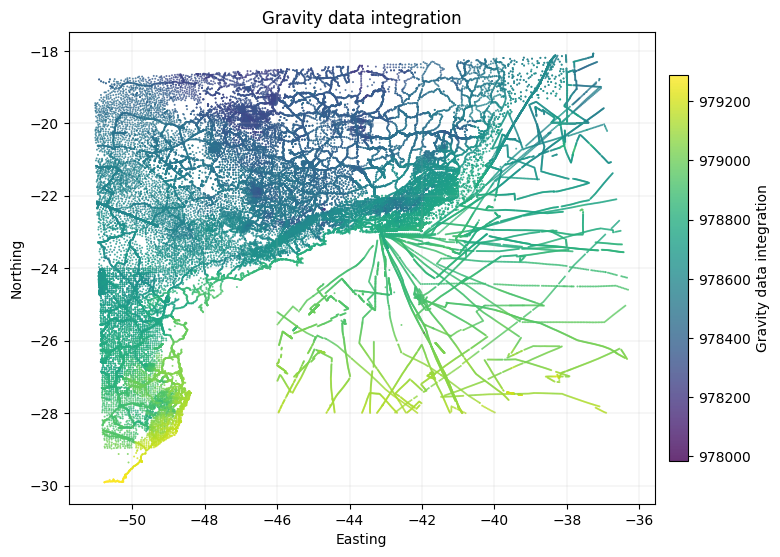

In [37]:
plot_gdf_scatter(x=grav_gpd.geometry.x, y=grav_gpd.geometry.y, c=grav_gpd.GRAV_OBS.values, cmap='viridis', title="Gravity data integration", centered_to_zero='no')

## **1.2 Topography**
Obter dados usando a biblioteca pystac-client.


#### Verificar variáveis da AOI

In [38]:
aoi_gdf_wgs84

,geometry
0,"POLYGON ((-50.78218 -30.013, -35.7111 -28.8158..."


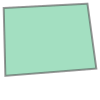

In [39]:
aoi_gdf_wgs84_geom

#### Conectar-se ao catálogo STAC e fazer a busca na coleção cop-dem-glo-30

In [40]:
# Conectar-se ao catálogo STAC do Planetary Computer
catalog_url = 'https://planetarycomputer.microsoft.com/api/stac/v1'
#client = pystac_client.Client.open(catalog_url)
catalog = Client.open(catalog_url)
print(catalog.title, catalog.description)

Microsoft Planetary Computer STAC API Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [41]:
from shapely.geometry import shape, mapping

aoi_buffer = aoi_gdf_wgs84_geom.buffer(1.2) # aplicar um buffer de x grau
aoi_gdf_wgs84_geom_buffer = mapping(aoi_buffer)# GeoJSON para consulta STAC

# Fazer busca
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects=aoi_gdf_wgs84_geom_buffer,
    max_items=200
)

items = list(search.items())
print(f"✅ {len(items)} tiles encontrados com buffer.") if items else print("❌ Nenhum item encontrado.")


✅ 132 tiles encontrados com buffer.


In [42]:
# Informações dos tiles obtidos
tile_info = []

for item in items:
    props = item.properties
    tile_info.append({
        "id": item.id,
        "datetime": props.get("datetime"),
        "bbox": item.bbox,
        "epsg": props.get("proj:epsg"),
        "geometry_type": item.geometry['type']
    })

df_tiles = pd.DataFrame(tile_info)
print(df_tiles.head())

                                         id              datetime  \
0  Copernicus_DSM_COG_10_S32_00_W052_00_DEM  2021-04-22T00:00:00Z   
1  Copernicus_DSM_COG_10_S32_00_W051_00_DEM  2021-04-22T00:00:00Z   
2  Copernicus_DSM_COG_10_S31_00_W052_00_DEM  2021-04-22T00:00:00Z   
3  Copernicus_DSM_COG_10_S31_00_W051_00_DEM  2021-04-22T00:00:00Z   
4  Copernicus_DSM_COG_10_S30_00_W053_00_DEM  2021-04-22T00:00:00Z   

                                                bbox  epsg geometry_type  
0  [-52.00013888888889, -31.999861111111112, -51....  None       Polygon  
1  [-51.00013888888889, -31.999861111111112, -50....  None       Polygon  
2  [-52.00013888888889, -30.999861111111112, -51....  None       Polygon  
3  [-51.00013888888889, -30.999861111111112, -50....  None       Polygon  
4  [-53.00013888888889, -29.999861111111112, -52....  None       Polygon  


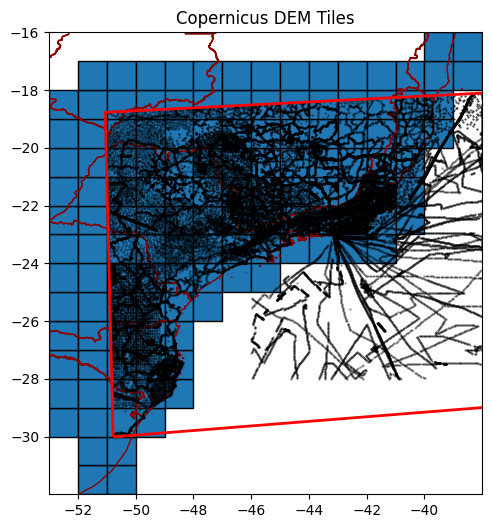

In [43]:
# Criar GeoDataFrames dos footprints dos items
geoms = [shape(item.geometry) for item in items]
gdf = gpd.GeoDataFrame({
    "id": [item.id for item in items],
    "datetime": [item.properties.get("datetime") for item in items],
    "epsg": [item.properties.get("proj:epsg") for item in items]
}, geometry=geoms, crs="EPSG:4326")

# Plotar localização das imagens encontradas
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, legend=True, edgecolor='black')
aoi_gdf.to_crs(gdf.crs)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
brasil.plot(ax=ax, edgecolor='darkred', linewidth=1, facecolor='None')
grav_gpd.plot(ax=ax, color='black', alpha=0.5, markersize=0.25)
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')
plt.title("Copernicus DEM Tiles")
plt.show()

#### Baixar os tiles selecionados - Mosaicar - Salvar como tif

In [44]:
#os.makedirs("/content/tiles", exist_ok=True) # Colab
os.makedirs("./tiles", exist_ok=True) # Local

In [45]:
# Baixar os tiles selecionados e mosaicar
from planetary_computer import sign

for item in items:
    try:
        signed_item = sign(item)
        url = signed_item.assets["data"].href
        tile_id = item.id.replace(":", "_")
        #out_path = f"/content/tiles/{tile_id}.tif"
        out_path = f"./tiles/{tile_id}.tif"

        if not os.path.exists(out_path):
            print(f"⬇️ Baixando: {tile_id}")
            response = requests.get(url, stream=True)
            with open(out_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        else:
            print(f"✔️ Já existe: {tile_id}")
    except Exception as e:
        print(f"⚠️ Falha ao baixar {item.id}: {e}")

''' # Colab
# Mosaico
!gdal_merge.py -o /content/ribeira-campos_copernicus.tif -of GTiff /content/tiles/*.tif

# Compressão
!gdal_translate /content/ribeira-campos_copernicus.tif \
  /content/ribeira-campos_copernicus_compressed.tif \
  -co COMPRESS=DEFLATE -co TILED=YES'''


✔️ Já existe: Copernicus_DSM_COG_10_S32_00_W052_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S32_00_W051_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S31_00_W052_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S31_00_W051_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S30_00_W053_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S30_00_W052_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S30_00_W051_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S30_00_W050_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S29_00_W053_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S29_00_W052_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S29_00_W051_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S29_00_W050_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S29_00_W049_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S28_00_W053_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S28_00_W052_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S28_00_W051_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S28_00_W050_00_DEM
✔️ Já existe: Copernicus_DSM_COG_10_S28_00_W049_00_DEM
✔️ Já exis

' # Colab\n# Mosaico\n!gdal_merge.py -o /content/ribeira-campos_copernicus.tif -of GTiff /content/tiles/*.tif\n\n# Compressão\n!gdal_translate /content/ribeira-campos_copernicus.tif   /content/ribeira-campos_copernicus_compressed.tif   -co COMPRESS=DEFLATE -co TILED=YES'

*Mosaiking in the Windows Python system:*

In [46]:
# Local 

def mosaic_rio(diretorio_tiles, output_path):
    from rasterio.merge import merge
    import glob
    import os

    # TIF files
    tile_paths = sorted(glob.glob(os.path.join(diretorio_tiles, "*.tif")))
    if not tile_paths:
        raise FileNotFoundError(f"Nenhum arquivo .tif encontrado em: {diretorio_tiles}")

    print(f"{len(tile_paths)} arquivos encontrados. Iniciando mosaico...")

    # Open raster files as rasterio obj
    src_files_to_mosaic = [rasterio.open(fp) for fp in tile_paths]

    # Mosaic
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Metadata (from the firts tile)
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "compress": "deflate",  # compression
        "tiled": True,  # optimization for chunks
        "BIGTIFF": "YES" # TIFs > 4 GB
    })

    # Save file
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    print(f"Mosaic file saved as {output_path}")


mosaic_rio(
    diretorio_tiles="./tiles",
    output_path="ribeira_copernicus_mosaic.tif"
)


132 arquivos encontrados. Iniciando mosaico...
Mosaic file saved as ribeira_copernicus_mosaic.tif


###### Escrever arquivo TIF de saída com economia de recursos (em blocos)

In [47]:
'''# Colab

from rasterio.windows import Window

input_path = "ribeira_copernicus_mosaic.tif"
output_path = "ribeira_copernicus_mosaic_compressed.tif"

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        nodata=-9999,
        compress='deflate',
        tiled=True,
        blockxsize=256,
        blockysize=256
    )

    with rasterio.open(output_path, 'w', **profile) as dst:
        for ji, window in src.block_windows(1):
            block = src.read(1, window=window)
            block_masked = np.where(block >= 0, block, -9999)
            dst.write(block_masked, 1, window=window)'''

'# Colab\n\nfrom rasterio.windows import Window\n\ninput_path = "ribeira_copernicus_mosaic.tif"\noutput_path = "ribeira_copernicus_mosaic_compressed.tif"\n\nwith rasterio.open(input_path) as src:\n    profile = src.profile.copy()\n    profile.update(\n        nodata=-9999,\n        compress=\'deflate\',\n        tiled=True,\n        blockxsize=256,\n        blockysize=256\n    )\n\n    with rasterio.open(output_path, \'w\', **profile) as dst:\n        for ji, window in src.block_windows(1):\n            block = src.read(1, window=window)\n            block_masked = np.where(block >= 0, block, -9999)\n            dst.write(block_masked, 1, window=window)'

#### Adicionar valores do DEM COP30 ao gpd (dado grav recortado)

In [48]:
# Obter valores do DEM

dem_path = "./ribeira_copernicus_mosaic.tif"

with rasterio.open(dem_path) as dem:
    if grav_gpd.crs != dem.crs:
      print(f"DEM CRS:{dem.crs}")
      print(f"Grav CRS:{grav_gpd.crs}")
      grav_gpd = grav_gpd.to_crs(dem.crs)
      print(f"   grav_gdf.to_crs(dem.crs):{grav_gpd.crs}")
    coords = [(pt.x, pt.y) for pt in grav_gpd.geometry] # usa geometria para amostrar
    alt_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)
    # nodata → NaN
    if dem.nodata is not None:
      alt_vals[alt_vals == dem.nodata] = np.nan

grav_gpd["ALT_ORTCO"] = alt_vals
grav_gpd.loc[grav_gpd["ALT_ORTCO"] <= 0, "ALT_ORTCO"] = np.nan

grav_gpd

DEM CRS:GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Grav CRS:EPSG:4674
   grav_gdf.to_crs(dem.crs):GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORT,source_file,geometry,ALT_ORTCO
0,-29.77850,-50.17630,979265.73,16.09,on_bndg.zip,POINT (-50.1763 -29.7785),19.883072
1,-29.77811,-50.17436,979265.70,0.00,ibge.zip,POINT (-50.17436 -29.77811),16.733934
2,-29.77810,-50.17580,979265.73,16.09,on_bndg.zip,POINT (-50.1758 -29.7781),19.496881
3,-29.77100,-50.19520,979268.40,NaN,on_bndg.zip,POINT (-50.1952 -29.771),NaN
4,-29.77060,-50.19470,979268.40,7.75,on_bndg.zip,POINT (-50.1947 -29.7706),9.825072
...,...,...,...,...,...,...,...
77730,-18.43610,-41.02450,978415.13,416.26,on_bndg.zip,POINT (-41.0245 -18.4361),404.525574
77731,-18.43075,-41.03097,978412.55,0.00,ibge.zip,POINT (-41.03097 -18.43075),412.757080
77732,-18.40910,-41.03640,978405.72,439.04,on_bndg.zip,POINT (-41.0364 -18.4091),515.588745
77733,-18.37424,-41.02715,978432.45,0.00,ibge.zip,POINT (-41.02715 -18.37424),289.681000


In [49]:
# Salvar backup
grav_gpd.to_file("./grav_gpd_copernicus.gpkg", driver="GPKG")

# Download
# files.download("/content/grav_gdf_copernicus.gpkg")    # Colab

## **2.3 Obter batimetria**

In [50]:
url = "https://www.marinha.mil.br/dhn/sites/www.marinha.mil.br.dhn/files/DTM_Brasil_LatLongProf.zip"
output_filename = "DTM_Brasil_LatLongProf.zip"
output_dir = "./DTM_Brasil_LatLongProf/"

# Download zip file
print(f"Downloading {url}...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(output_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded {output_filename} successfully.")

    # Unzip
    print(f"Unzipping {output_filename} to {output_dir}...")
    os.makedirs(output_dir, exist_ok=True)
    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("Unzipping complete.")

except requests.exceptions.RequestException as e:
    print(f"Error during download or unzip: {e}")
except zipfile.BadZipFile:
    print(f"Error: The downloaded file {output_filename} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Downloaded DTM_Brasil_LatLongProf.zip successfully.
Unzipping DTM_Brasil_LatLongProf.zip to ./DTM_Brasil_LatLongProf/...
Unzipping complete.


In [51]:
df_bathymetry = pd.read_csv(
    './DTM_Brasil_LatLongProf/DTM_Brasil_MAR21_1000m.XYZ',
    sep='\s+', #delim_whitespace=True, # whitespace delimiter
    names=['LATITUDE', 'LONGITUDE', 'BAT']
)

# Create a GeoDataFrame
geometry = gpd.points_from_xy(df_bathymetry['LONGITUDE'], df_bathymetry['LATITUDE'])
gdf_bathymetry = gpd.GeoDataFrame(df_bathymetry, geometry=geometry, crs='EPSG:4326')

print("Batimetria GeoDataFrame criado:")
print(gdf_bathymetry.head())
print(gdf_bathymetry.crs)  # WGS 84 (World Geodetic System)


Batimetria GeoDataFrame criado:
    LATITUDE  LONGITUDE     BAT                     geometry
0 -37.499877 -47.475963 -5102.6  POINT (-47.47596 -37.49988)
1 -37.499877 -47.466980 -5102.7  POINT (-47.46698 -37.49988)
2 -37.499877 -47.457996 -5103.0    POINT (-47.458 -37.49988)
3 -37.499877 -47.449013 -5103.1  POINT (-47.44901 -37.49988)
4 -37.499877 -47.440030 -5103.5  POINT (-47.44003 -37.49988)
EPSG:4326


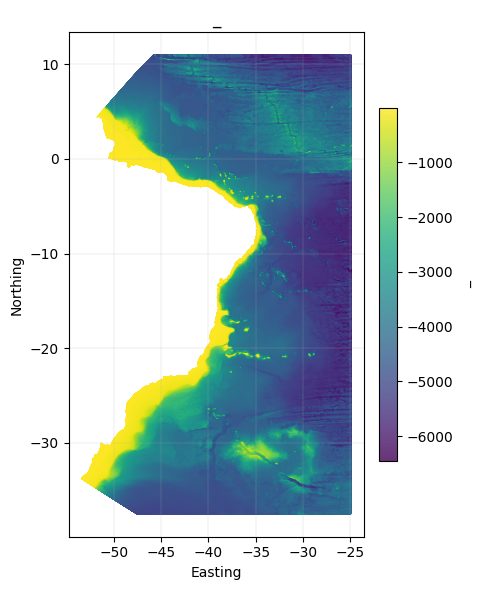

In [52]:
plot_gdf_scatter(x=gdf_bathymetry.geometry.x, y=gdf_bathymetry.geometry.y, c=gdf_bathymetry.BAT.values, cmap='viridis', title="_", centered_to_zero='no')

In [69]:
# Reprojetar temporariamente para metros (ex: UTM zone ou CRS do projeto)
aoi_proj = aoi_gdf_wgs84.to_crs(crs_projeto)

# Aplicar buffer em metros correspondente a 1.2 graus
buffer_m = 1.3 * 111000
aoi_proj_buffered = aoi_proj.buffer(buffer_m)

# Voltar ao WGS84 para manter tudo em graus
aoi_gdf_wgs84_buffered = aoi_proj_buffered.to_crs("EPSG:4326")


# Recortar usando within corretamente (e evitar o warning de índice)
from shapely.geometry import MultiPolygon
buffer_geom = aoi_gdf_wgs84_buffered.union_all()

gdf_bat_win = gdf_bathymetry[gdf_bathymetry.geometry.within(buffer_geom)]

gdf_bat_win = gdf_bat_win.to_crs(crs_projeto)

In [54]:
print(gdf_bat_win.crs)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


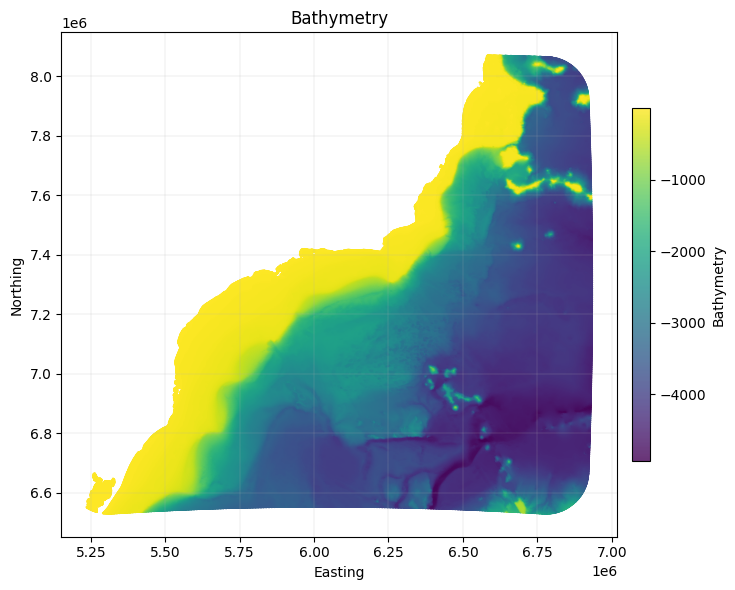

In [70]:
plot_gdf_scatter(x=gdf_bat_win.geometry.x, y=gdf_bat_win.geometry.y, c=gdf_bat_win.BAT.values, cmap='viridis', title="Bathymetry", centered_to_zero='no')

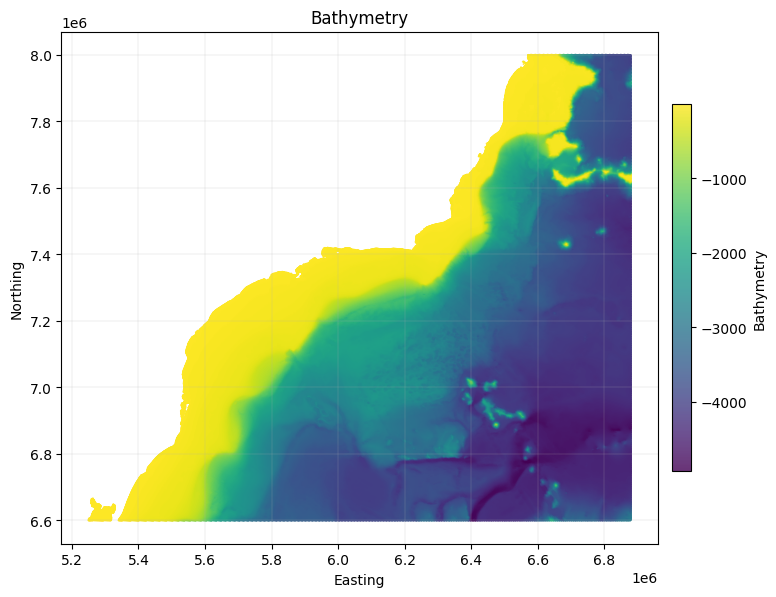

In [76]:
xmin = 5200000
xmax = 6880000
ymin = 6600000
ymax = 8000000

# Filtrar pelo bounding box
gdf_bat_win2 = gdf_bat_win[
    (gdf_bat_win.geometry.x >= xmin) & (gdf_bat_win.geometry.x <= xmax) &
    (gdf_bat_win.geometry.y >= ymin) & (gdf_bat_win.geometry.y <= ymax)
].copy()

plot_gdf_scatter(x=gdf_bat_win2.geometry.x, y=gdf_bat_win2.geometry.y, c=gdf_bat_win2.BAT.values, cmap='viridis', title="Bathymetry", centered_to_zero='no')

In [61]:
del zip

In [78]:
# Rasterize the resulting bat

from rasterio.features import rasterize
from rasterio.transform import from_origin

# Bounds
minx, miny, maxx, maxy = gdf_bat_win2.total_bounds

# Resolution
res = 1000
width = int((maxx - minx) / res)
height = int((maxy - miny) / res)

# Create the Affine transform
transform = from_origin(minx, maxy, res, res)

# Criar pares de (geometria, valor)
shapes = ((geom, value) for geom, value in zip(gdf_bat_win2.geometry, gdf_bat_win2["BAT"]))

# Rasterizar
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

# Salvar GeoTIFF
with rasterio.open(
    "./bat_win.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs=crs_projeto,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from tqdm import tqdm
from pyproj import Transformer

def estimate_bathymetry_ckdtree(grav_gpd, gdf_bat_win, window_km=5):
    """
    Estima valores de BAT onde há pontos com ALT_ORTCO ausente usando cKDTree.
    Esta função substitui o uso do cálculo "haversine", que utilizava graus. Por isso, 
    od dados tem que estar com crs em projetadas
    """
    # Converter para coordenadas projetadas de grav_gdf
    transformer = Transformer.from_crs("EPSG:4326", grav_gdf.crs, always_xy=True)
    grav_proj_x, grav_proj_y = transformer.transform(grav_gdf['LONGITUDE'].values, grav_gdf['LATITUDE'].values)
    bathy_proj_x, bathy_proj_y = transformer.transform(gdf_bat_win['LONGITUDE'].values, gdf_bat_win['LATITUDE'].values)

    # Construir cKDTree com dados de batimetria
    bathy_coords = np.vstack((bathy_proj_x, bathy_proj_y)).T
    bathy_tree = cKDTree(bathy_coords)

    estimated_bats = np.full(len(grav_proj_x), np.nan)

    radius = window_km * 1000 # --> m

    # Garantir coluna numérica
    bat_values = pd.to_numeric(gdf_bat_win['BAT'], errors='coerce').values

    # Loop com barra de progresso
    for i in tqdm(range(len(grav_proj_x)), desc="Estimando BAT"):
        idx = bathy_tree.query_ball_point([grav_proj_x[i], grav_proj_y[i]], r=radius)
        if idx:
            vals = bat_values[idx]
            vals = vals[~np.isnan(vals)]
            if len(vals) > 0:
                estimated_bats[i] = np.mean(vals)

    return estimated_bats

# Filtrar apenas os pontos sem ALT_ORTCO
grav_nan = grav_gpd[grav_gpd['ALT_ORTCO'].isna()].copy()

# Estimar
grav_nan['BAT'] = estimate_bathymetry_ckdtree(grav_nan, gdf_bat_win, window_km=5)

# Atribuir de volta ao GeoDataFrame principal
grav_gpd.loc[grav_nan.index, 'BAT'] = grav_nan['BAT']
grav_gpd['ALT'] = grav_gpd['ALT_ORTCO'].fillna(-grav_gpd['BAT'])

Estimando BAT:   5%|▌         | 12080/237607 [20:34<6:23:58,  9.79it/s]


KeyboardInterrupt: 

In [ ]:
from scipy.spatial import cKDTree
from pyproj import Transformer
from tqdm import tqdm

def estimate_bathymetry_ckdtree_fast(grav_gpd, gdf_bat_win, window_km=5):
    """
    Estima valores de BAT para pontos gravimétricos sem ALT_ORTCO,
    usando cKDTree vetorizado.
    """
    # Transformação para CRS projetado
    transformer = Transformer.from_crs("EPSG:4326", grav_gpd.crs, always_xy=True)
    
    grav_x, grav_y = transformer.transform(grav_gpd['LONGITUDE'].values, grav_gpd['LATITUDE'].values)
    bathy_x, bathy_y = transformer.transform(gdf_bat_win['LONGITUDE'].values, gdf_bat_win['LATITUDE'].values)
    
    grav_coords = np.vstack((grav_x, grav_y)).T
    bathy_coords = np.vstack((bathy_x, bathy_y)).T

    radius = window_km * 1000  # em metros

    # BAT valores válidos
    bat_values = pd.to_numeric(gdf_bat_win['BAT'], errors='coerce').values
    valid_mask = (~np.isnan(bat_values)) & (bat_values < 0)

    # Filtra apenas batimetria válida
    bat_coords_valid = bathy_coords[valid_mask]
    bat_values_valid = bat_values[valid_mask]

    # Criar KD-trees
    grav_tree = cKDTree(grav_coords)
    bat_tree = cKDTree(bat_coords_valid)

    # Encontrar vizinhos para todos os pontos de uma vez
    neighbors = grav_tree.query_ball_tree(bat_tree, r=radius)

    # Calcular médias com tqdm
    estimated_bats = np.full(len(grav_coords), np.nan)
    for i in tqdm(range(len(grav_coords)), desc="Estimando BAT"):
        idx = neighbors[i]
        if idx:
            estimated_bats[i] = np.mean(bat_values_valid[idx])

    return estimated_bats


grav_nan = grav_gpd[grav_gpd['ALT_ORTCO'].isna()].copy()
grav_nan['BAT'] = estimate_bathymetry_ckdtree_fast(grav_nan, gdf_bat_win, window_km=5)

# Atualiza os valores estimados no GeoDataFrame principal
grav_gpd.loc[grav_nan.index, 'BAT'] = grav_nan['BAT']
grav_gpd['ALT'] = grav_gpd['ALT_ORTCO'].fillna(-grav_gpd['BAT'])


MemoryError: bad allocation

In [ ]:
''' #Versao anterior sem cKDTree
def estimate_bathymetry(grav_gdf_row, gdf_bathymetry, window_size_km=5):
    """
    Estimates the bathymetry (BAT) for a gravimetric point by averaging
    nearby bathymetry points within a given window size.

    Args:
        grav_gdf_row (pd.Series): A single row from the grav_gdf where ALT_ORTCO is NaN.
                                 Should contain 'LONGITUDE' and 'LATITUDE'.
        gdf_bathymetry (gpd.GeoDataFrame): The GeoDataFrame containing bathymetry points
                                         with 'LONGITUDE', 'LATITUDE', and 'BAT' columns.
        window_size_km (int): The radius in kilometers to search for nearby bathymetry points.

    Returns:
        float: The estimated bathymetry value (average of nearby points), or np.nan
               if no nearby bathymetry points are found within the window.
    """
    grav_lon = grav_gdf_row['LONGITUDE']
    grav_lat = grav_gdf_row['LATITUDE']

    # Calculate distances to all bathymetry points
    # Ensure both dataframes have the correct coordinate columns and are numeric
    gdf_bathymetry['LONGITUDE'] = pd.to_numeric(gdf_bathymetry['LONGITUDE'], errors='coerce')
    gdf_bathymetry['LATITUDE'] = pd.to_numeric(gdf_bathymetry['LATITUDE'], errors='coerce')
    gdf_bathymetry = gdf_bathymetry.dropna(subset=['LONGITUDE', 'LATITUDE'])


    distances = gdf_bathymetry.apply(
        lambda row: haversine(grav_lon, grav_lat, row['LONGITUDE'], row['LATITUDE']),
        axis=1
    )

    # Filter for bathymetry points within the window size
    nearby_bat_points = gdf_bathymetry[distances <= window_size_km]

    # Estimate bathymetry by averaging, if points are found
    if not nearby_bat_points.empty:
        # Ensure 'BAT' column is numeric, coercing errors to NaN and dropping
        nearby_bat_points['BAT'] = pd.to_numeric(nearby_bat_points['BAT'], errors='coerce')
        nearby_bat_points = nearby_bat_points.dropna(subset=['BAT'])

        if not nearby_bat_points.empty:
             # We take the average of the 'BAT' values
            estimated_bat = nearby_bat_points['BAT'].mean()
            return estimated_bat
        else:
             return np.nan # No valid numeric 'BAT' values found in nearby points
    else:
        return np.nan # No nearby bathymetry points found

grav_gdf['BAT'] = np.nan
nan_alt_mask = grav_gdf['ALT_ORTCO'].isna()
# subset of the grav_gdf where ALT_ORTCO is NaN
grav_gdf.loc[nan_alt_mask, 'BAT'] = grav_gdf.loc[nan_alt_mask].apply(
    lambda row: estimate_bathymetry(row, gdf_bathymetry, window_size_km=5), axis=1
)

print("\nGrav_gdf with estimated BAT values:")
print(grav_gdf[['LONGITUDE', 'LATITUDE', 'ALT_ORTCO', 'BAT']].head())

grav_gdf['ALT'] = grav_gdf['ALT_ORTCO'].fillna(-grav_gdf['BAT'])
print(grav_gdf.head())

'''

In [ ]:
# Salvar como GeoPackage
grav_gdf.to_file("grav_step01__aoi_pts_rawgrav-dem.gpkg", layer='grav', driver="GPKG")

print("✅ Output file 'grav_step01__aoi_pts_rawgrav-dem.gpkg'")